In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
import torch

In [2]:
df = pd.read_csv("./data_train.csv")
test = pd.read_csv("./smiles_test.csv")
sample_submission = pd.read_csv("./sample_submission.csv")

## Investigate data

In [3]:
df.head()

,Unnamed: 0,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,0,CC1=NN(c2ccc(C)c(C)c2)C(=O)C1N=Nc1cccc(-c2cccc...,0,0,0,0,0,0,0,0,0,0,0
1,1,CCOP(=S)(OCC)Oc1ccc(S(C)=O)cc1,0,0,0,0,0,0,0,0,-1,-1,0
2,2,CN(c1ccccc1CN=c1[nH]c(Nc2ccc3c(c2)CC(=O)N3)ncc...,0,0,0,0,0,0,0,-1,0,0,0
3,3,CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(N(C)C...,0,0,0,0,0,0,0,0,1,1,1
4,4,O=C(O)C1(C(O)=Nc2ccc(Cl)cc2Cl)CC1,0,0,0,0,0,0,0,0,0,1,0


In [4]:
print(df.shape)

(12000, 13)


## Take a look at the submission format

In [5]:
sample_submission.head()

,Unnamed: 0,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,0,0.965388,0.669021,0.364129,0.248534,0.082723,0.101662,0.894853,0.099291,0.931158,0.132221,0.617906
1,1,0.972610,0.986971,0.060073,0.286885,0.865854,0.805776,0.481583,0.715330,0.388927,0.998184,0.378946
2,2,0.366591,0.275695,0.063553,0.966171,0.442205,0.969089,0.509688,0.540241,0.441256,0.164225,0.070570
3,3,0.475604,0.490168,0.755998,0.477857,0.371955,0.947405,0.280805,0.872361,0.513712,0.570384,0.990165
4,4,0.034529,0.669413,0.480047,0.011377,0.747641,0.272674,0.322530,0.330088,0.929216,0.492997,0.496907


## Preprocessing 

### Drop unnecessary axis and remove rows where we only have zeros

In [6]:
df = df.drop(labels = "Unnamed: 0", axis = 1)
df = df[(df == 0).sum(1) < 11]

In [7]:
print("DF Shape: ",df.shape)

DF Shape:  (11531, 12)


### Normalize values between 0 and 1

In [8]:
df[df.columns[1:]] = (df[df.columns[1:]]+1)/2

In [9]:
df.head()

,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
1,CCOP(=S)(OCC)Oc1ccc(S(C)=O)cc1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.5
2,CN(c1ccccc1CN=c1[nH]c(Nc2ccc3c(c2)CC(=O)N3)ncc...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
3,CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(N(C)C...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0
4,O=C(O)C1(C(O)=Nc2ccc(Cl)cc2Cl)CC1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5
5,CCN1C(=CC=Cc2sc3ccccc3[n+]2CC)Sc2ccccc21,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,0.5


# Exploratory Data Analyis

In [10]:
#Insert string lenght of Smiles representation
df.insert(1, 'smiles_length', df['smiles'].str.len())

## Distribution of length of Smiles representation over all Molecules

# Feature Engineering

## Calculate information about number of rings & atoms, types of atoms & bonds

In [11]:
num_rings = []
activities = []
num_atoms = []
all_atoms = []
all_bonds = []
mols = []

for smile in df["smiles"]:
    mols.append(Chem.rdmolfiles.MolFromSmiles(smile))
    
for mol in mols:
    ring = mol.GetRingInfo()
    num_r = ring.NumRings()
    num_a = mol.GetNumAtoms()
    num_rings.append(num_r)
    num_atoms.append(num_a)
        
    atoms = []
    bonds = []
    
    for m in mol.GetAtoms():
        atoms.append(m.GetAtomicNum())
        
    for m in mol.GetBonds():
        bonds.append(str(m.GetBondType()))
        
    all_atoms.append(atoms)
    all_bonds.append(bonds)

In [12]:
#investiage features of one sample 
x = 1
print("activities: ", activities[:x])
print("num rings:",num_rings[:x])
print("num atoms:",num_atoms[:x])
print("all atoms:",all_atoms[:x])
print("all bonds:",all_bonds[:x])

activities:  []
num rings: [1]
num atoms: [18]
all atoms: [[6, 6, 8, 15, 16, 8, 6, 6, 8, 6, 6, 6, 6, 16, 6, 8, 6, 6]]
all bonds: [['SINGLE', 'SINGLE', 'SINGLE', 'DOUBLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'AROMATIC', 'AROMATIC', 'AROMATIC', 'SINGLE', 'SINGLE', 'DOUBLE', 'AROMATIC', 'AROMATIC', 'AROMATIC']]


In [13]:
mol_info = pd.DataFrame(df["smiles"].values, columns = ["smiles"])
mol_info["num_rings"] = num_rings
mol_info["num_atoms"] = num_atoms

In [14]:
all_bonds_flat = []
for x in all_bonds:
    all_bonds_flat += x
    
unique_bonds = list(set(all_bonds_flat))
del all_bonds_flat

In [15]:
#create empty df to fill in the features
cols = list(str(i) + "_p" for i in range(1,119))
cols += unique_bonds
fill = np.zeros([len(mol_info),len(cols)])
atoms_table = pd.DataFrame(fill, columns = cols)

atoms_table.head()

,1_p,2_p,3_p,4_p,5_p,6_p,7_p,8_p,9_p,10_p,...,113_p,114_p,115_p,116_p,117_p,118_p,DOUBLE,SINGLE,TRIPLE,AROMATIC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#filling the feature table, this step takes some time to execute (~ 2min)
for idx in range(len(all_atoms)):
    mol = all_atoms[idx]
    bonds = all_bonds[idx]
    
    for atom in mol:
        atoms_table.loc[idx, str(atom)+"_p"] += 1
        
    for bond in bonds:
        atoms_table.loc[idx, bond] += 1

In [17]:
atoms_table.head()

,1_p,2_p,3_p,4_p,5_p,6_p,7_p,8_p,9_p,10_p,...,113_p,114_p,115_p,116_p,117_p,118_p,DOUBLE,SINGLE,TRIPLE,AROMATIC
0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
1,0.0,0.0,0.0,0.0,0.0,22.0,6.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,0.0,18.0
2,0.0,0.0,0.0,0.0,0.0,29.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,1.0,6.0
3,0.0,0.0,0.0,0.0,0.0,11.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
4,0.0,0.0,0.0,0.0,0.0,21.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,16.0


In [18]:
df_features = mol_info.join(atoms_table, how = "inner")

In [19]:
print(df_features.shape)
df_features.head()

(11531, 125)


,smiles,num_rings,num_atoms,1_p,2_p,3_p,4_p,5_p,6_p,7_p,...,113_p,114_p,115_p,116_p,117_p,118_p,DOUBLE,SINGLE,TRIPLE,AROMATIC
0,CCOP(=S)(OCC)Oc1ccc(S(C)=O)cc1,1,18,0.0,0.0,0.0,0.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
1,CN(c1ccccc1CN=c1[nH]c(Nc2ccc3c(c2)CC(=O)N3)ncc...,4,35,0.0,0.0,0.0,0.0,0.0,22.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,0.0,18.0
2,CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(N(C)C...,5,32,0.0,0.0,0.0,0.0,0.0,29.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,1.0,6.0
3,O=C(O)C1(C(O)=Nc2ccc(Cl)cc2Cl)CC1,2,17,0.0,0.0,0.0,0.0,0.0,11.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
4,CCN1C(=CC=Cc2sc3ccccc3[n+]2CC)Sc2ccccc21,4,25,0.0,0.0,0.0,0.0,0.0,21.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,16.0


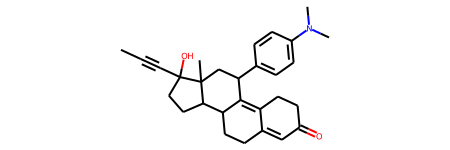

In [20]:
Chem.rdmolfiles.MolFromSmiles(df_features["smiles"][2])

In [21]:
df = df.reset_index().drop(labels = ["index", "smiles", "smiles_length"], axis = 1)
df = df_features.join(df, how = "inner")
smiles = df["smiles"].to_list()
df = df.drop(labels = "smiles", axis = 1)
print(df.shape)


(11531, 135)


In [22]:
#The final df for building models
df.head()

,num_rings,num_atoms,1_p,2_p,3_p,4_p,5_p,6_p,7_p,8_p,...,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,1,18,0.0,0.0,0.0,0.0,0.0,11.0,0.0,4.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.5
1,4,35,0.0,0.0,0.0,0.0,0.0,22.0,6.0,3.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
2,5,32,0.0,0.0,0.0,0.0,0.0,29.0,1.0,2.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0
3,2,17,0.0,0.0,0.0,0.0,0.0,11.0,1.0,3.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5
4,4,25,0.0,0.0,0.0,0.0,0.0,21.0,2.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,0.5


In [23]:
#Morgan Fingerprints
from rdkit.Chem import AllChem

mutag = [Chem.rdmolfiles.MolFromSmiles(smile) for smile in smiles]

# Initialize variables
fp_length = 2048
desc_mtx = np.zeros((len(mutag), fp_length)) * np.nan
compounds = [''] * len(mutag)

# Calculate Morgan fingerprints (equivalent to ECFP fingerprints)
for i, mol in enumerate(mutag): 
    if mol is not None:
        desc_mtx[i] = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=fp_length)

df_morgan = pd.DataFrame(desc_mtx)

In [24]:
print(df_morgan.columns)

RangeIndex(start=0, stop=2048, step=1)


In [25]:
X_train = df[df.columns[:len(df.columns)-11]]
y_train = df[df.columns[len(df.columns)-11:]]

In [26]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


def get_relevant_features(X,y,alpha):
    
    mod = sm.OLS(y,X)
    fii = mod.fit()
    df_p = pd.DataFrame(fii.summary2().tables[1]['P>|t|'])
    
    df_p.columns = ["p_val"]
    df_p = df_p.fillna(1)
    
    features = df_p.index[df_p['p_val'] < alpha].tolist()
    
    X = X[features]
    
    return X
    
get_relevant_features(X_train, y_train["task1"], 1)

,num_rings,num_atoms,1_p,2_p,3_p,4_p,5_p,6_p,7_p,8_p,...,78_p,79_p,80_p,81_p,83_p,98_p,DOUBLE,SINGLE,TRIPLE,AROMATIC
0,1,18,0.0,0.0,0.0,0.0,0.0,11.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
1,4,35,0.0,0.0,0.0,0.0,0.0,22.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,0.0,18.0
2,5,32,0.0,0.0,0.0,0.0,0.0,29.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,1.0,6.0
3,2,17,0.0,0.0,0.0,0.0,0.0,11.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
4,4,25,0.0,0.0,0.0,0.0,0.0,21.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11526,0,7,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
11527,2,25,0.0,0.0,0.0,0.0,0.0,17.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,12.0
11528,4,26,0.0,0.0,0.0,0.0,0.0,21.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,25.0,0.0,0.0
11529,1,11,0.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0


In [27]:
X_train = X_train.reset_index(drop=True).fillna(0)
y_train = y_train.reset_index(drop=True).fillna(0)

# Model building

In [28]:
#error metric: ROC AUC score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [29]:
df[df.columns[len(df.columns)-11:]]

,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.5
1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0
3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5
4,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...
11526,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.5
11527,0.5,0.5,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5
11528,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
11529,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5


In [30]:
X_train

,num_rings,num_atoms,1_p,2_p,3_p,4_p,5_p,6_p,7_p,8_p,...,113_p,114_p,115_p,116_p,117_p,118_p,DOUBLE,SINGLE,TRIPLE,AROMATIC
0,1,18,0.0,0.0,0.0,0.0,0.0,11.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
1,4,35,0.0,0.0,0.0,0.0,0.0,22.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,0.0,18.0
2,5,32,0.0,0.0,0.0,0.0,0.0,29.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,1.0,6.0
3,2,17,0.0,0.0,0.0,0.0,0.0,11.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,6.0
4,4,25,0.0,0.0,0.0,0.0,0.0,21.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11526,0,7,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
11527,2,25,0.0,0.0,0.0,0.0,0.0,17.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,12.0
11528,4,26,0.0,0.0,0.0,0.0,0.0,21.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,25.0,0.0,0.0
11529,1,11,0.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0


In [31]:
y_train

,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.5
1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0
3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5
4,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...
11526,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.5
11527,0.5,0.5,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5
11528,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
11529,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5


In [32]:
def preprocess_df(df, test_data=False, fp_length=512, radius = 2):
    '''
    Function that preprocesses a df that contains smiles data. 
    If 'test_data=False' returns processed x and y values.
    If 'test_data=True' returns only processed x values.
    '''
    if "Unnamed: 0" in df.columns:
        df = df.drop(labels = "Unnamed: 0", axis = 1)
    
    if test_data == False:
        df = df[(df == 0).sum(1) < 11]
    
    num_rings = []
    activities = []
    num_atoms = []
    all_atoms = []
    all_bonds = []
    mols = []

    for smile in df["smiles"]:
        mols.append(Chem.rdmolfiles.MolFromSmiles(smile))

    for mol in mols:
        ring = mol.GetRingInfo()
        num_r = ring.NumRings()
        num_a = mol.GetNumAtoms()
        num_rings.append(num_r)
        num_atoms.append(num_a)

        atoms = []
        bonds = []

        for m in mol.GetAtoms():
            atoms.append(m.GetAtomicNum())

        for m in mol.GetBonds():
            bonds.append(str(m.GetBondType()))

        all_atoms.append(atoms)
        all_bonds.append(bonds)
        
    mol_info = pd.DataFrame(df["smiles"].values, columns = ["smiles"])
    mol_info["num_rings"] = num_rings
    mol_info["num_atoms"] = num_atoms
    
    all_bonds_flat = []
    
    for bond in all_bonds:
        all_bonds_flat += bond

    unique_bonds = list(set(all_bonds_flat))
    del all_bonds_flat
    
    #create empty df to fill in the features
    cols = list(str(i) + "_p" for i in range(1,119))
    cols += unique_bonds
    fill = np.zeros([len(mol_info),len(cols)])
    atoms_table = pd.DataFrame(fill, columns = cols)
    
    for idx in range(len(all_atoms)):
        mol = all_atoms[idx]
        bonds = all_bonds[idx]
    
    for atom in mol:
        atoms_table.loc[idx, str(atom)+"_p"] += 1
        
    for bond in bonds:
        atoms_table.loc[idx, bond] += 1
        
    df_features = mol_info.join(atoms_table, how = "inner")
    
    df = df.reset_index().drop(labels = ["index", "smiles"], axis = 1)
    df = df_features.join(df, how = "inner")
    smiles = df["smiles"].to_list()
    mutag = [Chem.rdmolfiles.MolFromSmiles(smile) for smile in smiles]
    df = df.drop(labels = "smiles", axis = 1)

    desc_mtx = np.zeros((len(mutag), fp_length)) * np.nan    
    for i, mol in enumerate(mutag): 
        if mol is not None:
            desc_mtx[i] = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=fp_length)

    df_morgan = pd.DataFrame(desc_mtx)
    
    if test_data:
        x = df
        x = x.join(df_morgan, how = "inner")
        
        return x
        
    else:
        x = df[df.columns[:len(df.columns)-11]]
        y = df[df.columns[len(df.columns)-11:]]
        x = x.join(df_morgan, how = "inner")
        
        return x, y

In [33]:
submission_x = preprocess_df(test, True, 2048, 3)

In [126]:
#error metric: ROC AUC score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
import sklearn.ensemble as ensemble
from sklearn.model_selection import KFold


models = {}
features = {}
rocs = []

for i,col in enumerate(y_train.columns):
    
    
    y = y_train[col]
    idx = y.index[y != 0.5].tolist()
    y = y[idx]
    x = X_train.iloc[idx]
    
    alpha = 0.1
    
    df_morgan_ = df_morgan.iloc[idx]
    #df_morgan_ = get_relevant_features(df_morgan_,y, alpha)
    x = x.join(df_morgan_, how = "inner")
    
    features[i] = x.columns
        
    
    print(" ")
    print("Model " + str(i) + " ------------------------")
    print("Data Shape: " + str(x.shape))
    print(" ")
    
    X_train_, X_test_, y_train_, y_test_ = train_test_split(x, y, test_size=0.2)
    
    X_train_ = X_train_.reset_index(drop=True).fillna(0)
    y_train_ = y_train_.reset_index(drop=True).fillna(0)
    
    X_test_ = X_test_.reset_index(drop=True).fillna(0)
    y_test_ = y_test_.reset_index(drop=True).fillna(0)

    n_estimators = 120

    n_splits = 5
    cv = KFold(n_splits=n_splits)
    
    x = x.reset_index(drop=True).fillna(0)
    y = y.reset_index(drop=True).fillna(0)
    
    svc_ensemble = []
    
    for train, test in cv.split(x,y):
        X_train_, X_test_, y_train_, y_test_ = x.iloc[train], x.iloc[test], y[train], y[test]
        
        svc = SVC(probability=True)

        svc.fit(X_train_, y_train_)
        y_pred = svc.predict_proba(X_test_)[:,1]
        print(y_pred[:5])
        roc = roc_auc_score(y_test_, y_pred)
        print("ROC: {:.4f}".format(roc))

    
        svc_ensemble.append(svc)
    
        rocs.append(roc)
    
    models[i] = svc_ensemble

print("")
print("Mean Test ROC: ",np.mean(np.array(accs)))  

 
Model 0 ------------------------
Data Shape: (1010, 2172)
 
[0.06129683 0.06240187 0.06092764 0.06137662 0.06269667]
ROC: 0.7484
[0.06075923 0.05993528 0.06047768 0.06314735 0.05994704]
ROC: 0.4688
[0.05969424 0.0576939  0.05946582 0.05977011 0.06030588]
ROC: 0.7242
[0.06172819 0.05610427 0.06027736 0.06060332 0.05601798]
ROC: 0.5651
[0.04463519 0.05817746 0.04820939 0.03772786 0.0588391 ]
ROC: 0.5707
 
Model 1 ------------------------
Data Shape: (1023, 2172)
 
[0.63417225 0.40236091 0.57145868 0.16885844 0.58312524]
ROC: 0.8317
[0.30230781 0.34580441 0.8347947  0.21431976 0.2099787 ]
ROC: 0.8196
[0.41504484 0.17800815 0.09004823 0.16145417 0.23082229]
ROC: 0.7896
[0.36333466 0.6289602  0.20672174 0.20124573 0.17479706]
ROC: 0.7962
[0.24872022 0.23284837 0.36890157 0.69816088 0.1601591 ]
ROC: 0.8386
 
Model 2 ------------------------
Data Shape: (1314, 2172)
 
[0.06137667 0.86186166 0.91504214 0.85770581 0.69982018]
ROC: 0.8532
[0.81000033 0.92135039 0.88485699 0.88474758 0.89640835

In [122]:
predictions = []

for key, cv_models in enumerate(models):
    tmp = []
    for model in models[key]:
        tmp.append(model.predict_proba(submission_x[features[key]])[:,1])
    
    cv_mean = np.mean(np.array(tmp), axis=0)
    predictions.append(cv_mean)
        
print(np.array(predictions), np.array(predictions).shape)

[[0.06038286 0.06038286 0.06002605 ... 0.06030406 0.06022676 0.06069158]
 [0.23589977 0.23589977 0.26696913 ... 0.23598611 0.23818101 0.18231667]
 [0.81432354 0.81445074 0.44056667 ... 0.76348476 0.73573491 0.75092354]
 ...
 [0.10047828 0.10285307 0.34648247 ... 0.19904248 0.23292781 0.02570675]
 [0.0701234  0.07278561 0.07299671 ... 0.07219353 0.07110769 0.06940899]
 [0.66557267 0.66438194 0.67522323 ... 0.66855906 0.66976293 0.66021474]] (11, 5896)


In [ ]:
#error metric: ROC AUC score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
import sklearn.ensemble as ensemble
from sklearn.model_selection import KFold


models = {}
features = {}
accs = []

for i,col in enumerate(y_train.columns):
    
    
    y = y_train[col]
    idx = y.index[y != 0.5].tolist()
    y = y[idx]
    x = X_train.iloc[idx]
    
    alpha = 0.1
#     df_des_ = df_des.iloc[idx]
#     df_des_ = get_relevant_features(df_des_,y, alpha)
#     x = x.join(df_des_, how = "inner")
    
    
    df_morgan_ = df_morgan.iloc[idx]
    df_morgan_ = get_relevant_features(df_morgan_,y, alpha)
    x = x.join(df_morgan_, how = "inner")
    
    features[i] = x.columns
        
    
    print(" ")
    print("Model " + str(i) + " ------------------------")
    print("Data Shape: " + str(x.shape))
    print(" ")
    
    X_train_, X_test_, y_train_, y_test_ = train_test_split(x, y, test_size=0.2)
    
    X_train_ = X_train_.reset_index(drop=True).fillna(0)
    y_train_ = y_train_.reset_index(drop=True).fillna(0)
    
    X_test_ = X_test_.reset_index(drop=True).fillna(0)
    y_test_ = y_test_.reset_index(drop=True).fillna(0)
    
    
    # Fit classifier with out-of-bag estimates
    params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
              'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    clf = ensemble.GradientBoostingClassifier(**params)

    clf.fit(X_train_, y_train_)
    acc = clf.score(X_test_, y_test_)
    print("Accuracy: {:.4f}".format(acc))

    n_estimators = params['n_estimators']

    def heldout_score(clf, X_test, y_test):
        """compute deviance scores on ``X_test`` and ``y_test``. """
        score = np.zeros((n_estimators,), dtype=np.float64)
        for i, y_pred in enumerate(clf.staged_decision_function(X_test_)):
            score[i] = roc_auc_score(y_test_, y_pred)
        return score


    def cv_estimate(n_splits=None):
        cv = KFold(n_splits=n_splits)
        cv_clf = ensemble.GradientBoostingClassifier(**params)
        val_scores = np.zeros((n_estimators,), dtype=np.float64)
        for train, test in cv.split(X_train_, y_train_):
            cv_clf.fit(X_train_.iloc[train], y_train_[train])
            val_scores += heldout_score(cv_clf, X_train_.iloc[test], y_train_[test])
        val_scores /= n_splits
        return val_scores


    # Estimate best n_estimator using cross-validation
    cv_score = cv_estimate(3)

    # Compute best n_estimator for test data
    test_score = heldout_score(clf, X_test_, y_test_)
    
    print("cv_score", np.mean(cv_score))
    print("test_score", np.mean(test_score))

    # negative cumulative sum of oob improvements
    cumsum = -np.cumsum(clf.oob_improvement_)

    # min loss according to OOB
    oob_best_iter = X_train_.values[np.argmin(cumsum)]

    # min loss according to test (normalize such that first loss is 0)
    test_score -= test_score[0]
    #test_best_iter = X_train_.values[np.argmin(test_score)]

    # min loss according to cv (normalize such that first loss is 0)
    #cv_score -= cv_score[0]
    #cv_best_iter = X_train_.values[np.argmin(cv_score)]
    
#     print("")
#     print("CV *****")
#     print("")
#     print("cv_score", np.mean(cv_score))
#     print("test_score", np.mean(test_score))

    
    #cv_results = cross_validate(model, x, y, cv=5, scoring="roc_auc")
    
    #print("Cross Validation AUC Test Score")
    #print(sum(cv_results['test_score']) / len(cv_results['test_score']))
    
    models[i] = clf
    
    accs.append(cv_score)

print("")
print("Mean Test ROC: ",np.mean(np.array(accs)))  

In [68]:
import tensorflow as tf
from tensorflow import keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.regularizers as regularizers
from sklearn.model_selection import KFold


models = {}
accs = []
features = {}

for i,col in enumerate(y_train.columns):

    y = y_train[col]
    idx = y.index[y != 0.5].tolist()
    y = y[idx]
    x = X_train.iloc[idx]
    
    alpha = 0.1
#     df_des_ = df_des.iloc[idx]
#     df_des_ = get_relevant_features(df_des_,y, alpha)
#     x = x.join(df_des_, how = "inner")
    
    
    df_morgan_ = df_morgan.iloc[idx]
    df_morgan_ = get_relevant_features(df_morgan_,y, alpha)
    x = x.join(df_morgan_, how = "inner")
    
    features[i] = x.columns


    
    print(" ")
    print("Model " + str(i) + " ------------------------")
    print("Data Shape: " + str(x.shape))
    print(" ")
    
#     X_train_, X_test_, y_train_, y_test_ = train_test_split(x, y, test_size=0.2)
        
#     input_size = x.shape[1]
#     output_size = 1
#     epochs = y.shape[0]

#     lr = 0.001
    
#     model = tf.keras.models.Sequential()
#     model.add(layers.Dense(input_size, activation="sigmoid", name="layer1"))
#     model.add(layers.Dense(1024, activation="relu", name="layer2"))
#     model.add(layers.Dense(output_size, activation="sigmoid", name="layer3"))

#     optimizer = keras.optimizers.Adam(learning_rate=lr)
    
#     callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
#     model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.AUC()])
#     history = model.fit(X_train_, y_train_, epochs=12, validation_data=(X_test_,y_test_), callbacks=[callback])
    
    cv_models = []
    cv_accs = []
    
    n_splits = 5
    cv = KFold(n_splits=n_splits)
    
    x = x.reset_index(drop=True).fillna(0)
    y = y.reset_index(drop=True).fillna(0)
    
    for train, test in cv.split(x,y):
            
        X_train_, X_test_, y_train_, y_test_ = x.iloc[train], x.iloc[test], y[train], y[test]
        
        input_size = x.shape[1]
        output_size = 1
        epochs = y.shape[0]

        lr = 0.001
        
        model = tf.keras.models.Sequential()
        model.add(layers.Dense(input_size, activation="sigmoid", name="layer1"))
        model.add(layers.Dense(1024, activation="relu", name="layer2"))
        model.add(layers.Dense(output_size, activation="sigmoid", name="layer3"))        

        optimizer = keras.optimizers.Adam(learning_rate=lr)

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.AUC()])
        history = model.fit(X_train_, y_train_, epochs=12, validation_data=(X_test_,y_test_), callbacks=[callback],verbose=0)
        
        cv_models.append(model)
        
        accs.append(history.history[list(history.history.keys())[3]])
        cv_accs.append(history.history[list(history.history.keys())[3]])
    
#     weights = [model for model in cv_models]
#     #model[1].get_weights()
    

#     new_weights = list()
#     for weights_list_tuple in zip(*weights): 
#         new_weights.append(
#             np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
#         )
        
#     model = tf.keras.models.Sequential()
#     model.add(layers.Dense(input_size, activation="sigmoid", name="layer1"))
#     model.add(layers.Dense(1024, activation="relu", name="layer2"))
#     model.add(layers.Dense(output_size, activation="sigmoid", name="layer3"))
#     model.set_weights(new_weights)
    print("*****************")
    print("CV AUC")
    try:
        print(np.mean(np.array(cv_accs)))
    except:
        pass
    
    models[i] = cv_models

 
Model 0 ------------------------
Data Shape: (1010, 124)
 
*****************
CV AUC
0.6044781297445297
 
Model 1 ------------------------
Data Shape: (1023, 132)
 
*****************
CV AUC
0.7530692001183827
 
Model 2 ------------------------
Data Shape: (1314, 265)
 
*****************
CV AUC
0.8581845422585805
 
Model 3 ------------------------
Data Shape: (953, 644)
 
*****************
CV AUC
0.7838086783885956
 
Model 4 ------------------------
Data Shape: (632, 732)
 
*****************
CV AUC
0.7725588222344716
 
Model 5 ------------------------
Data Shape: (632, 394)
 
*****************
CV AUC
0.7813384354114532
 
Model 6 ------------------------
Data Shape: (610, 2123)
 
*****************
CV AUC
0.7372352083524069
 
Model 7 ------------------------
Data Shape: (3804, 312)
 
*****************
CV AUC


<ipython-input-68-cf8413ab71a0>:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.mean(np.array(cv_accs)))


 
Model 8 ------------------------
Data Shape: (3626, 436)
 
*****************
CV AUC
0.8669602274894714
 
Model 9 ------------------------
Data Shape: (4311, 424)
 
*****************
CV AUC
0.830363463362058
 
Model 10 ------------------------
Data Shape: (962, 267)
 
*****************
CV AUC
0.6207330832878749


In [89]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch import nn
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Grayscale, ToPILImage
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from tqdm.notebook import tqdm
from time import sleep, time, strftime
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns; sns.set()
import math
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def accuracy(logits, targets):

    y_hat = logits
    y = targets
    
    correct = []

    y_for_acc = torch.argmax(torch.nn.functional.softmax(y_hat.detach()).data, axis=1)
    correct.append(torch.sum((y_for_acc == y).float()) / len(y))

    return sum(correct) / len(correct)

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    error_list = []
    accs = []
    counter = 0
    network.eval()
    network.to(device)
    
    with torch.no_grad():
        for x, y in data:
            x_tensor = torch.tensor(x)
            y_tensor = torch.tensor(y).float()

            x_tensor = x_tensor.to(device)
            y_tensor = y_tensor.to(device)

            y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
            
            prediction = network.forward(x_tensor)
            error_list.append(metric(prediction, y_tensor))
            
            try:
                accs.append(roc_auc_score(y_tensor, prediction))
            except:
                pass
            
            counter += 1
        
    return error_list, accs
        

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module, 
           opt: optim.Optimizer) -> list:
    error_list = []
    counter = 0
    network.train()
    network.to(device)
    
    for x, y in data:     
        x_tensor = torch.tensor(x)
        y_tensor = torch.tensor(y).float()
        
        x_tensor = x_tensor.to(device)
        y_tensor = y_tensor.to(device)
        
        y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
        
        logits = network(x_tensor)
        
        le = loss(logits, y_tensor)
        opt.zero_grad()

        error_list.append(le)
        le.backward()

        opt.step()
        counter += 1
        
    print("Loss: ", torch.mean(torch.tensor(error_list)).item() )

    
    return error_list

    raise NotImplementedError("TODO: copy `update` from previous assignment!")

overall_roc = []
    
for i,col in enumerate(y_train.columns):

    y = y_train[col]
    idx = y.index[y != 0.5].tolist()
    y = y[idx]
    x = X_train.iloc[idx]
    
    x = x.reset_index(drop=True).fillna(0).values
    y = y.reset_index(drop=True).fillna(0).values
                        
    X_train_, X_test_, y_train_, y_test_ = train_test_split(x, y, test_size=0.2)

    
    train_data = []
    for i in range(len(X_train_)):
        train_data.append([X_train_[i], y_train_[i]])
    
    val_data = []
    for i in range(len(X_test_)):
        val_data.append([X_test_[i], y_test_[i]])
        
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=128)
    valloader = torch.utils.data.DataLoader(val_data, batch_size=128)

    
    class SNN(nn.Module):

        def __init__(self, in_dim, hidden_dim, out_dim, n_layers, dropout_prob=0.0, bias=True):
            super().__init__()
            layers = OrderedDict()
            n_layer = n_layers - 1

            for i in range(n_layers):
                if i == 0:
                    layers["Linear_" + str(i)] = nn.Linear(in_dim, hidden_dim, bias=bias)
                else:
                    layers["Linear_" + str(i)] = nn.Linear(hidden_dim, hidden_dim, bias=bias)
                layers["SELU_" + str(i)] = nn.SELU()
                layers["AlphaDropout_" + str(i)] = nn.AlphaDropout(p=dropout_prob)

            layers["Linear_" + str(n_layers)] = nn.Linear(hidden_dim, out_dim, bias=bias)
            layers["Sigmoid"] = nn.Sigmoid()

            self.net = nn.Sequential(layers)
            self.apply(self._weights_init)


        @staticmethod
        def _weights_init(layer):       
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=math.sqrt(1/layer.in_features)),
                nn.init.constant_(layer.bias, 0)


        def forward(self, x):
            y_hat = self.net(x.float())
            return y_hat
    
    input_size = x.shape[1]
    net = SNN(input_size, 200, 1, 4) # (input, hidden, output, n_layers)
    
    lr= 0.001
    
    adam = optim.Adam(net.parameters(), lr=lr)
    ce = nn.BCELoss()

    train_errs, valid_errs = [], []
    
    print("Model **************" + str(i))
    
    for i in range(15):
        print("Epoch " + str(i))

        local_errs = update(net, trainloader, ce, adam)
        train_errs.append(sum(local_errs) / len(local_errs))
        local_valid_errs, rocs = evaluate(net, valloader, ce)
        valid_errs.append(sum(rocs) / len(rocs))
    
        print("ROC on validation: ", valid_errs[-1].item())
        
        tmp = valid_errs[-1]
    
    overall_roc.append(tmp)

print("Overall ROC", np.mean(np.array(overall_roc)))

cpu
Model **************201
Epoch 0
Loss:  0.8814254403114319
ROC on validation:  0.560956416464891
Epoch 1
Loss:  0.4010940194129944


<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.5477905569007264
Epoch 2
Loss:  0.31219086050987244
ROC on validation:  0.5420399515738499
Epoch 3
Loss:  0.24778112769126892


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.5102905569007263
Epoch 4
Loss:  0.23372067511081696
ROC on validation:  0.5163438256658596
Epoch 5
Loss:  0.2206706553697586
ROC on validation:  0.4897699757869249
Epoch 6


<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.21254301071166992
ROC on validation:  0.4997578692493946
Epoch 7
Loss:  0.2146027833223343
ROC on validation:  0.48062953995157387
Epoch 8
Loss:  0.2078787237405777
ROC on validation:  0.4840496368038741
Epoch 9


<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.20754237473011017
ROC on validation:  0.4795399515738499
Epoch 10
Loss:  0.2077091783285141
ROC on validation:  0.48099273607748183
Epoch 11
Loss:  0.2047918289899826
ROC on validation:  0.47699757869249393
Epoch 12


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.2039337158203125
ROC on validation:  0.4766646489104116
Epoch 13
Loss:  0.20440392196178436
ROC on validation:  0.47708837772397095
Epoch 14
Loss:  0.20343579351902008
ROC on validation:  0.4753934624697337
Model **************204

<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach


Epoch 0
Loss:  1.4894793033599854
ROC on validation:  0.6075376800566036
Epoch 1
Loss:  0.7435346841812134
ROC on validation:  0.6930754135127558
Epoch 2


<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6433680653572083
ROC on validation:  0.7222352383622359
Epoch 3
Loss:  0.6071562170982361
ROC on validation:  0.7238362235839108
Epoch 4
Loss:  0.5840634703636169


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.7351375705875286
Epoch 5
Loss:  0.5738476514816284
ROC on validation:  0.7372318341410016
Epoch 6
Loss:  0.5655254125595093
ROC on validation:  0.7388331531098562
Epoch 7


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.5589429140090942
ROC on validation:  0.7394802888915588
Epoch 8
Loss:  0.5523196458816528
ROC on validation:  0.7359696023068605
Epoch 9
Loss: 

<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

 0.5461114048957825
ROC on validation:  0.7422510579785602
Epoch 10
Loss:  0.5438798666000366
ROC on validation:  0.7454844006568144
Epoch 11
Loss:  0.5411242246627808
ROC on validation:  0.748378989947535
Epoch 12


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.537573516368866
ROC on validation:  0.7518279333039637
Epoch 13
Loss:  0.5361576676368713
ROC on validation:  0.7567547091727075
Epoch 14
Loss:  0.5336686968803406
ROC on validation:  0.7576167781382248
Model **************262
Epoch 0


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6747872829437256
ROC on validation:  0.708933098522429
Epoch 1
Loss:  0.46141889691352844
ROC on validation:  0.5390904657073311
Epoch 2
Loss:  0.4761386513710022


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.6612158435871854
Epoch 3
Loss:  0.4333908259868622
ROC on validation:  0.7216043424717326
Epoch 4
Loss:  0.41406601667404175


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.7862005436389166
Epoch 5
Loss:  0.4171229302883148
ROC on validation:  0.7904886067347485
Epoch 6
Loss:  0.40354442596435547


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.7945737290073164
Epoch 7
Loss:  0.40496087074279785
ROC on validation:  0.7979913910366552
Epoch 8
Loss:  0.3972107768058777
ROC on validation:  0.7996330682689465
Epoch 9
Loss:  0.3978484869003296
ROC on validation:  0.804937567550715
Epoch 10
Loss:  0.39035874605178833
ROC on validation:  0.8018430808437719
Epoch 11


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.38861778378486633
ROC on validation:  0.8045035397729373
Epoch 12
Loss:  0.38549065589904785
ROC on validation:  0.8046003191626944
Epoch 13
Loss:  0.37846696376800537


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.8077986217922071
Epoch 14
Loss:  0.3806837499141693
ROC on validation:  0.8084355903932491
Model **************190
Epoch 0
Loss:  0.8209841251373291


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.5993670692320644
Epoch 1
Loss:  0.3720291554927826
ROC on validation:  0.6133726714729607
Epoch 2
Loss:  0.3015206754207611
ROC on validation:  0.6005648160903705
Epoch 3
Loss:  0.3013409972190857
ROC on validation:  0.6072576571612252
Epoch 4
Loss:  0.26491042971611023
ROC on validation:  0.5930415882199875
Epoch 5
Loss:  0.26854121685028076
ROC on validation:  0.597090202201099
Epoch 6
Loss:  0.25178995728492737


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.6366732485343864
Epoch 7
Loss:  0.2555786371231079
ROC on validation:  0.6309676876214967
Epoch 8
Loss:  0.24648605287075043
ROC on validation:  0.6275963937487563
Epoch 9
Loss:  0.245411679148674
ROC on validation:  0.6241217798594848
Epoch 10
Loss:  0.24498802423477173
ROC on validation:  0.62848035389019
Epoch 11
Loss:  0.2388874888420105
ROC on validation:  0.6325787145459276
Epoch 12


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.23804648220539093
ROC on validation:  0.6287405672651574
Epoch 13
Loss:  0.23781241476535797
ROC on validation:  0.6255759134254795
Epoch 14
Loss:  0.2344677448272705
ROC on validation:  0.6227747929773002
Model **************126
Epoch 0


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  1.77487313747406
ROC on validation:  0.4688905547226387
Epoch 1
Loss:  1.0717484951019287
ROC on validation:  0.5810844577711144
Epoch 2
Loss:  0.8481437563896179
ROC on validation:  0.574087956021989
Epoch 3
Loss:  0.7735697627067566
ROC on validation:  0.597576211894053
Epoch 4
Loss:  0.7374970316886902
ROC on validation:  0.6193153423288357
Epoch 5


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6786117553710938
ROC on validation:  0.6003248375812095
Epoch 6
Loss:  0.7021596431732178
ROC on validation:  0.6168165917041479
Epoch 7
Loss:  0.672799825668335
ROC on validation:  0.6218140929535232
Epoch 8
Loss:  0.6624027490615845
ROC on validation:  0.6230634682658671
Epoch 9


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6632882356643677
ROC on validation:  0.6223138430784607
Epoch 10
Loss:  0.6435743570327759
ROC on validation:  0.618815592203898
Epoch 11
Loss:  0.6515234112739563
ROC on validation:  0.6208145927036482
Epoch 12
Loss:  0.6373270750045776
ROC on validation:  0.6148175912043978
Epoch 13


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6400678157806396
ROC on validation:  0.6148175912043978
Epoch 14
Loss:  0.6324073076248169
ROC on validation:  0.6120689655172413
Model **************126
Epoch 0
Loss:  1.1435948610305786
ROC on validation:  0.6392140468227423
Epoch 1
Loss:  0.5153396725654602
ROC on validation:  0.6099498327759196
Epoch 2


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.557854950428009
ROC on validation:  0.5794314381270903
Epoch 3
Loss:  0.47473692893981934
ROC on validation:  0.6091137123745819
Epoch 4
Loss:  0.48045459389686584
ROC on validation:  0.6061872909698997
Epoch 5
Loss:  0.45622819662094116
ROC on validation:  0.5936454849498327
Epoch 6
Loss:  0.4540359377861023


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.6091137123745819
Epoch 7
Loss:  0.4477503001689911
ROC on validation:  0.612876254180602
Epoch 8
Loss:  0.43629661202430725
ROC on validation:  0.6078595317725752
Epoch 9
Loss:  0.4370501935482025
ROC on validation:  0.5986622073578595
Epoch 10
Loss: 

<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

 0.4281706213951111
ROC on validation:  0.5932274247491638
Epoch 11
Loss:  0.4289925694465637
ROC on validation:  0.5944816053511705
Epoch 12
Loss:  0.4237355887889862
ROC on validation:  0.5944816053511705
Epoch 13
Loss:  0.4223966896533966
ROC on validation:  0.5957357859531771
Epoch 14
Loss:  0.4187381863594055


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.592391304347826
Model **************121
Epoch 0
Loss:  0.6623015999794006
ROC on validation:  0.2205357142857143
Epoch 1
Loss:  0.5247957706451416
ROC on validation:  0.825
Epoch 2
Loss:  0.3079627454280853
ROC on validation:  0.6419642857142858
Epoch 3
Loss: 

<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

 0.32402223348617554
ROC on validation:  0.5830357142857143
Epoch 4
Loss:  0.2804001271724701
ROC on validation:  0.7374999999999999
Epoch 5
Loss:  0.2591377794742584
ROC on validation:  0.7357142857142857
Epoch 6
Loss:  0.257057249546051
ROC on validation:  0.7401785714285714
Epoch 7
Loss:  0.24612805247306824


<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.75625
Epoch 8
Loss:  0.232815220952034
ROC on validation:  0.7535714285714286
Epoch 9
Loss:  0.23426054418087006
ROC on validation:  0.7607142857142857
Epoch 10
Loss:  0.22598490118980408
ROC on validation:  0.7482142857142857
Epoch 11
Loss:  0.21815797686576843
ROC on validation: 

<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

 0.7348214285714286
Epoch 12
Loss:  0.2178192138671875
ROC on validation:  0.7348214285714286
Epoch 13
Loss:  0.20983022451400757
ROC on validation:  0.73125
Epoch 14
Loss:  0.20960281789302826
ROC on validation:  0.7267857142857143
Model **************760
Epoch 0


<ipython-input-89-e0e7c15236f9>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))


Loss:  0.16435867547988892
ROC on validation:  0.7071509325091481
Epoch 1


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.06440512090921402
ROC on validation:  0.7374361945269176
Epoch 2


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.06505769491195679
ROC on validation:  0.7260876936358603
Epoch 3


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.06553356349468231
ROC on validation:  0.7220938360527516
Epoch 4


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.06540072709321976
ROC on validation:  0.7348262587709428
Epoch 5


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.06351250410079956
ROC on validation:  0.7404960834275854
Epoch 6


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.06171170249581337
ROC on validation:  0.7433676064053031
Epoch 7


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.061114922165870667
ROC on validation:  0.7478623872008093
Epoch 8


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.060572702437639236
ROC on validation:  0.7494178092736826
Epoch 9


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.05989043414592743
ROC on validation:  0.742240812660119
Epoch 10


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.05926712229847908
ROC on validation:  0.7416953943968578
Epoch 11


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.05871570110321045
ROC on validation:  0.7390357114397702
Epoch 12


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.05825814977288246
ROC on validation:  0.7354911992737151
Epoch 13


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.057581592351198196
ROC on validation:  0.7331499680700886
Epoch 14


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.05714608356356621
ROC on validation:  0.7370689022229273
Model **************725
Epoch 0


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6930183172225952
ROC on validation:  0.719433740636623
Epoch 1


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.4036470353603363
ROC on validation:  0.7368349995878197
Epoch 2


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.38169392943382263
ROC on validation:  0.7514068953467817
Epoch 3


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.37035560607910156
ROC on validation:  0.7595563894649939
Epoch 4


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.36087214946746826
ROC on validation:  0.7620838116995579
Epoch 5


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.3568267822265625
ROC on validation:  0.7591119087659094
Epoch 6


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.35529211163520813
ROC on validation:  0.7582523432109788
Epoch 7


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.3539116084575653
ROC on validation:  0.7576437097801844
Epoch 8


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.35304462909698486
ROC on validation:  0.7568198452441025
Epoch 9


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.3498436510562897
ROC on validation:  0.7601709680312706
Epoch 10


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.34779930114746094
ROC on validation:  0.7602658813269026
Epoch 11


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.34586334228515625
ROC on validation:  0.7561490596770412
Epoch 12


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.3438568711280823
ROC on validation:  0.7599722795946643
Epoch 13


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.34133994579315186
ROC on validation:  0.7559398462511764
Epoch 14


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.339643269777298
ROC on validation:  0.7597491577154402
Model **************862
Epoch 0


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.40100979804992676
ROC on validation:  0.7073095276185588
Epoch 1


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.24275216460227966
ROC on validation:  0.7271164383584559
Epoch 2


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.23177073895931244
ROC on validation:  0.7463743682838351
Epoch 3


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.23109690845012665
ROC on validation:  0.7481041017830892
Epoch 4


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.22809350490570068
ROC on validation:  0.757892055207787
Epoch 5


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.2268555611371994
ROC on validation:  0.758589100206427
Epoch 6


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.22558747231960297
ROC on validation:  0.7659685527132015
Epoch 7


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.22296251356601715
ROC on validation:  0.7700148681340325
Epoch 8


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.22227533161640167
ROC on validation:  0.7740400669917505
Epoch 9


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.22059288620948792
ROC on validation:  0.780186028687986
Epoch 10


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.2184590995311737
ROC on validation:  0.7831778852346608
Epoch 11


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.2170342206954956
ROC on validation:  0.7865243579214533
Epoch 12


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.21522942185401917
ROC on validation:  0.789876490999151
Epoch 13


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.21406501531600952
ROC on validation:  0.7885220354896647
Epoch 14


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.21222496032714844
ROC on validation:  0.7827437979067594
Model **************192
Epoch 0


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  1.4827710390090942
ROC on validation:  0.5710934061997892
Epoch 1
Loss:  1.375242829322815
ROC on validation:  0.5910156956256247
Epoch 2


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6733552813529968
ROC on validation:  0.573736350332095
Epoch 3
Loss:  0.6152300238609314
ROC on validation:  0.5516606456322768
Epoch 4


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.6315635442733765
ROC on validation:  0.5941251419974825
Epoch 5
Loss:  0.5898204445838928
ROC on validation:  0.5988899464076769
Epoch 6


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.5818772315979004
ROC on validation:  0.5780278298008794
Epoch 7
Loss:  0.5865758061408997
ROC on validation:  0.5764675631696908
Epoch 8


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Loss:  0.5645827651023865
ROC on validation:  0.5944871716148312
Epoch 9
Loss:  0.5610054731369019
ROC on validation:  0.5901372727613863
Epoch 10
Loss:  0.562942385673523


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

ROC on validation:  0.5976550373713494
Epoch 11
Loss:  0.5560821294784546
ROC on validation:  0.5999035440524803
Epoch 12
Loss:  0.5484893321990967
ROC on validation:  0.5994255285035426
Epoch 13
Loss:  0.545329213142395
ROC on validation:  0.6001504405759726
Epoch 14
Loss:  0.5442987680435181
ROC on validation:  0.5980332709056113
Overall ROC 0.6793692488072751


<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x)
<ipython-input-89-e0e7c15236f9>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).float()
<ipython-input-89-e0e7c15236f9>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.reshape(torch.tensor(y).float(), (len(y_tensor),1))
<ipython-input-89-e0e7c15236f9>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

In [70]:
accs = np.array(accs)[:,-1]  #last epoch
print("AUCs: ", accs)
print("")
print("Mean Test AUC over all tasks: ", np.mean(accs))

<ipython-input-70-0987e99dcda2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  accs = np.array(accs)[:,-1]  #last epoch


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [71]:
#Predict
predictions = []

for key, cv_models in enumerate(models.items()):
    tmp = []
    for model in cv_models[1]:
        tmp.append(model.predict(submission_x[features[key]]))
    
    cv_mean = np.mean(np.array(tmp), axis=0)
    predictions.append(cv_mean)
        
print(np.array(predictions).shape)

(11, 5896, 1)


In [123]:
print(np.array(predictions).shape)
print(np.mean(predictions), np.max(predictions), np.min(predictions))


(11, 5896)
0.2777299008889467 0.9597561533439982 0.0031978271399027403


In [124]:
predictions = np.array(predictions)
predictions_ = np.array(predictions).reshape((predictions.shape[0], predictions.shape[1]))
predictions_ = pd.DataFrame(predictions_.T)

In [125]:
predictions_.columns = y_train.columns
predictions_.to_csv("subm.csv", float_format='%.6f')


In [109]:
from sklearn import preprocessing
results = pd.DataFrame(predictions)
tmp_ = results.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(tmp_)
results = pd.DataFrame(x_scaled)
print(results.head())
results.to_csv("subm_scaled.csv")

         0         1         2         3         4         5         6   \
0  0.228763  0.830070  0.695628  0.127390  0.453533  0.070676  0.129857   
1  0.228763  0.830070  0.620000  0.100074  0.381251  0.070676  0.132229   
2  0.194853  0.253510  0.949015  0.031090  0.555520  0.070676  0.823582   
3  0.000000  0.448134  0.722129  0.328650  0.438269  0.246045  0.147066   
4  0.992967  0.208967  0.691716  0.037726  0.345556  0.095441  0.127258   

         7         8         9         10  
0  0.005458  0.118507  0.044963  0.725635  
1  0.003967  0.130868  0.117694  0.787646  
2  0.007738  0.611522  0.102614  0.725635  
3  0.069961  0.198075  0.142300  0.672037  
4  0.008046  0.501522  0.044963  0.560183  
